# Symbolic Aggregate Approximation & Piecewise Aggregate Approximation 

## SAX-PAA или верните мне мой 2007 

Оригинал статьи - https://cs.gmu.edu/~jessica/SAX_DAMI_preprint.pdf

Довольно старая работа, посвященная предобработке временного ряда с целью снижения размерности и сохранения информации об основных паттернах. Изначально предполагалось использовать для анализа финансовых временных рядов, но по факту используется в разных приложениях как один из возможных этапов препроцессинга. 

<img src="pictures/sax.png" width=600>

Основная идея метода заключается в том, что он преобразует временной ряд в низкоразмерный массив символов или чисел. Он состоит из двух шагов: сначала "кусочно-агрегатное" приближение (PAA) применяется к исходным данным для эффективного уменьшения размерности. Затем значения PAA дополнительно дискретизируются на фиксированное количество возможных значений с использованием гауссовых свойств значений z-нормированного временного ряда. По сути, среди значений PAA мы ищем значения, которые близки друг к другу, и маркируем их буквой (если мы используем строковое представление) или числом (если мы используем порядковое представление). Более подробное описание алгоритма можно найти [здесь](https://jmotif.github.io/sax-vsm_site/morea/algorithm/SAX.html).

Внезапное и очень прикольное свойство - полученные буквенные представления временных рядов можно действительно рассматривать как "слова" и использовать привычные нам NLP методы для работы. Например, для разных временных рядов можно нагенерировать тестовые SAX представления, посчитать между ними расстояния Левенштейна и найти наиболее похожие по паттернам временные ряды. Или вообще засунуть в tf-idf, нагенерировать векторные представления и вот вам новое признаковое пространство, которое учитывает особенности паттернов во временных рядах.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

Для работы PAA необходимо сначала z-нормализовать наши данные. Годное описание принципов работы PAA можно найти [здесь](https://vigne.sh/posts/piecewise-aggregate-approx/)

In [4]:
np.random.seed(0)
# Generate a random walk time series
n_ts, sz, d = 1, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(dataset)

# PAA transform (and inverse transform) of the data
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

In [5]:
paa.transform(dataset)

array([[[-0.01208612],
        [ 0.99632313],
        [ 1.0306829 ],
        [ 1.36363721],
        [ 0.7076021 ],
        [-0.02530004],
        [-0.91802305],
        [-1.31387456],
        [-1.38330975],
        [-0.44565183]]])

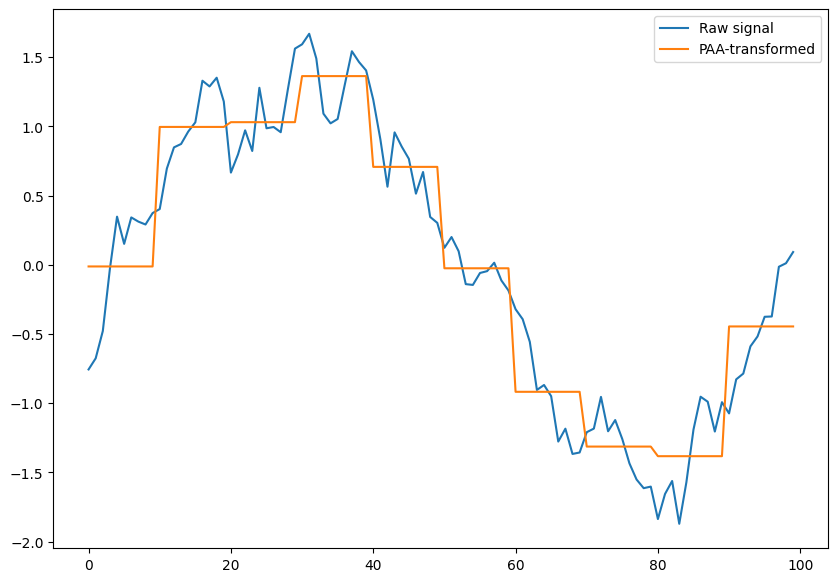

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(dataset.ravel(), label='Raw signal')
plt.plot(paa_dataset_inv.ravel(), label='PAA-transformed')
plt.legend()
plt.show()

In [7]:
# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols
)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

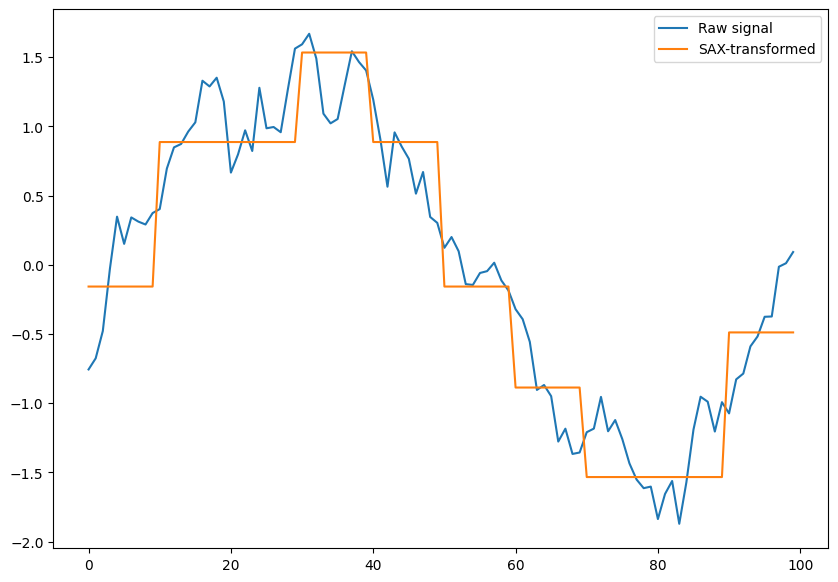

In [8]:
plt.figure(figsize=(10, 7))
plt.plot(dataset.ravel(), label='Raw signal')
plt.plot(sax_dataset_inv.ravel(), label='SAX-transformed')
plt.legend()
plt.show()

In [9]:
sax_numeric_representation = sax.transform(dataset).ravel()
sax_numeric_representation

array([3, 6, 6, 7, 6, 3, 1, 0, 0, 2])

In [10]:
sax_alphabet = list(string.ascii_lowercase[:n_sax_symbols])

sax_alphabet_map = dict(zip(range(n_sax_symbols), sax_alphabet))

sax_string_representation = [sax_alphabet_map[number] for number in sax_numeric_representation]
sax_string_representation = "".join(sax_string_representation)
sax_string_representation

'dgghgdbaac'

In [11]:
def get_string_sax(sax_numeric_representation, n_sax_symbols):
    
    sax_alphabet = list(string.ascii_lowercase[:n_sax_symbols])
    sax_alphabet_map = dict(zip(range(n_sax_symbols), sax_alphabet))

    sax_string_representation = [sax_alphabet_map[number] for number in sax_numeric_representation]
    sax_string_representation = "".join(sax_string_representation)
    return sax_string_representation

# Пример на наших игрушечных

In [12]:
x1 = np.arange(0, 50, 0.1)
x2 = np.arange(50, 100, 0.1)

location_shift = np.concatenate((
        np.random.normal(loc=0.0, size=len(x1)), 
        np.random.normal(loc=5.0, size=len(x2))))

scale_shift = np.concatenate((
        np.random.normal(loc=0.0, scale=1.0, size=len(x1)), 
        np.random.normal(loc=0.0, scale=4.0, size=len(x2))
    ))

seasonality_shift = np.concatenate((
        np.sin(x1) + np.random.normal(loc=0.0, scale=.2, size=len(x1)), 
        np.sin(x2/2) + np.random.normal(loc=0.0, scale=.2, size=len(x2)))
    )

shifts = [location_shift, scale_shift, seasonality_shift]

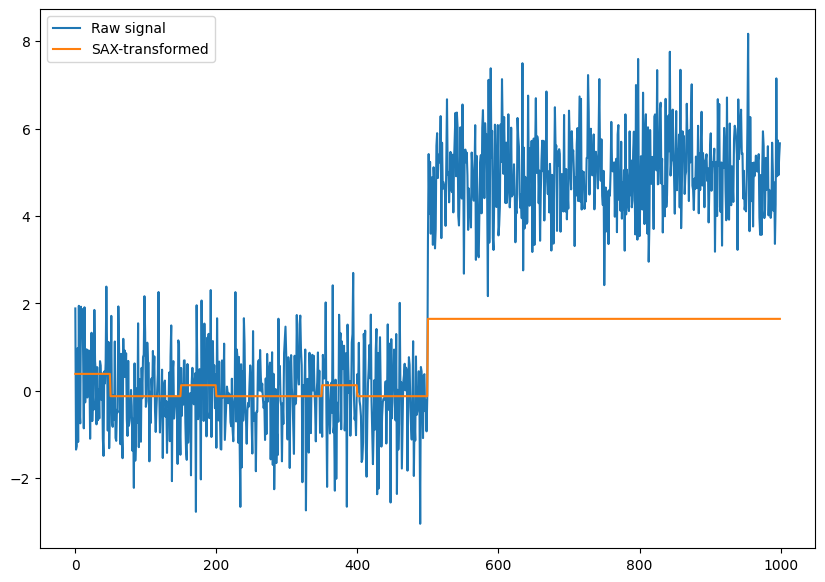

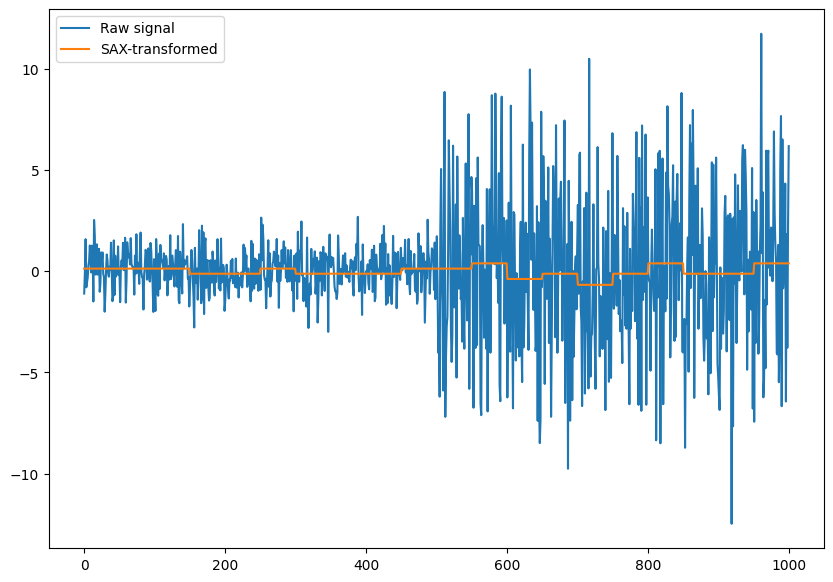

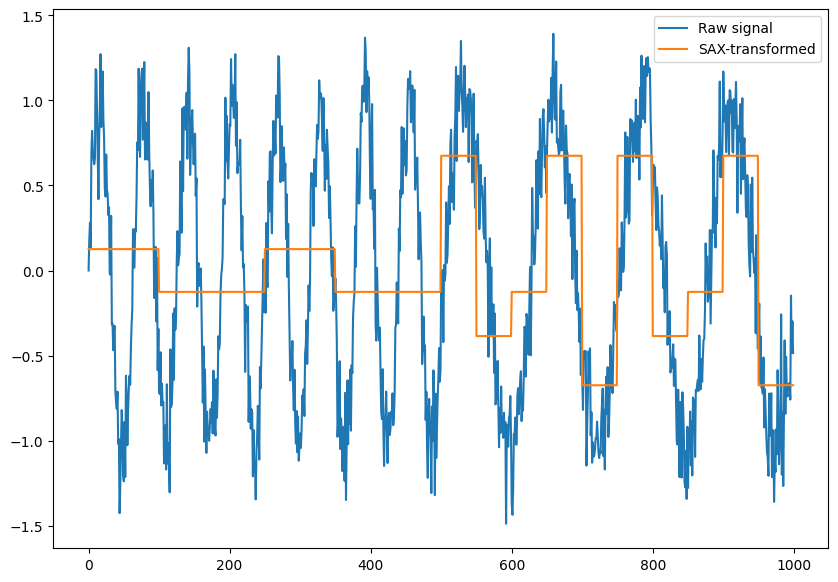

In [13]:
for shift in shifts:
    # SAX transform
    n_paa_segments = 20
    n_sax_symbols = 10
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                         alphabet_size_avg=n_sax_symbols)
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(shift.reshape(-1, 1).T))
    #print(sax.fit_transform(shift.reshape(-1, 1).T))

    plt.figure(figsize=(10, 7))
    plt.plot(shift, label='Raw signal')
    plt.plot(sax_dataset_inv.ravel(), label='SAX-transformed')
    plt.legend()
    plt.show()

---
# Пример сжатия размерности

(И еще один интересный пример для финансов - https://peijin.medium.com/using-sax-vsm-for-financial-time-series-classification-stock-prediction-38b4d10eeb19)

In [13]:
import pandas as pd
from tqdm.auto import tqdm

In [14]:
full_ticker_df = pd.read_csv("../data/raw/full_ticker_df_month_07_2021.csv", index_col=0)
datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [15]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

full_ticker_df.dropna(inplace=True)
full_ticker_df.shape

(88, 27)

In [16]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].values)

In [17]:
tickers_scaled.shape

(88, 22, 1)

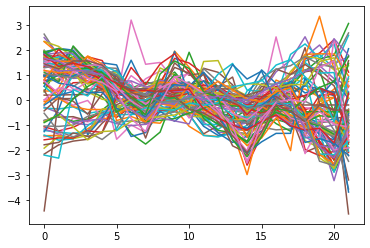

In [18]:
plt.plot(tickers_scaled[:, :, 0].T);

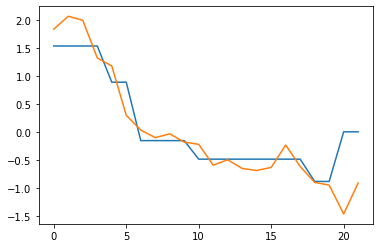

In [19]:
# SAX transform
n_paa_segments = 10
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(tickers_scaled))

plt.plot(sax_dataset_inv[0].ravel())
plt.plot(tickers_scaled[0, :, 0])

In [24]:
sax_transformed = sax.fit_transform(tickers_scaled)[:, :, 0]
sax_transformed#.shape

array([[7, 7, 6, 3, 3, 2, 2, 2, 2, 1],
       [6, 7, 5, 4, 4, 3, 2, 2, 5, 1],
       [7, 6, 6, 5, 6, 4, 1, 1, 1, 1],
       [1, 1, 2, 2, 3, 4, 4, 1, 5, 7],
       [2, 1, 3, 2, 3, 2, 0, 3, 7, 7],
       [0, 0, 1, 4, 4, 6, 6, 4, 5, 7],
       [7, 7, 2, 1, 4, 4, 4, 4, 4, 1],
       [7, 6, 6, 4, 4, 3, 1, 1, 0, 1],
       [5, 7, 6, 4, 4, 5, 5, 4, 4, 0],
       [0, 0, 2, 2, 3, 4, 3, 2, 4, 7],
       [7, 7, 5, 6, 4, 3, 1, 1, 2, 0],
       [7, 7, 5, 4, 3, 0, 0, 1, 5, 4],
       [6, 6, 3, 0, 2, 7, 2, 3, 4, 6],
       [6, 7, 6, 3, 6, 3, 1, 0, 4, 3],
       [0, 0, 2, 2, 3, 4, 4, 3, 5, 7],
       [7, 7, 6, 5, 4, 1, 1, 2, 2, 2],
       [0, 1, 2, 7, 6, 4, 4, 3, 3, 2],
       [6, 7, 7, 3, 3, 2, 1, 2, 4, 1],
       [6, 7, 5, 3, 5, 3, 3, 4, 5, 0],
       [2, 2, 2, 2, 2, 2, 1, 2, 6, 7],
       [7, 7, 6, 4, 4, 1, 0, 2, 2, 1],
       [5, 6, 5, 4, 7, 6, 1, 0, 2, 2],
       [1, 1, 3, 2, 2, 2, 2, 2, 5, 7],
       [7, 7, 5, 2, 2, 4, 4, 3, 4, 1],
       [7, 7, 6, 4, 4, 2, 1, 2, 1, 1],
       [7, 7, 6, 4, 5, 4,

In [25]:
sax_transformed.shape

(88, 10)

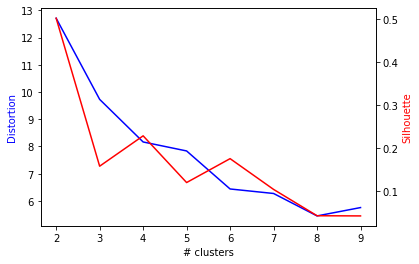

In [26]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(sax_transformed)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [27]:
n_clusters = 4

ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(sax_transformed)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, n_jobs=6)

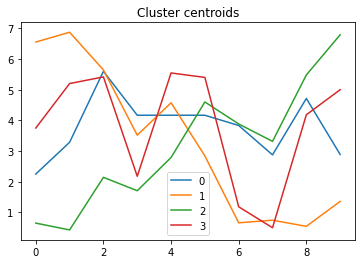

In [28]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [29]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(sax_transformed)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                   2
        Basic Materials              1
        Consumer Cyclical            1
        Energy                       1
        Healthcare                   1
1       Consumer Cyclical           15
        Healthcare                  12
        Technology                   8
        Communication Services       6
        Financial Services           6
        Industrials                  4
        Consumer Defensive           2
        Energy                       1
        Real Estate                  1
2       Consumer Cyclical            4
        Technology                   4
        Healthcare                   3
        Communication Services       2
        Industrials                  2
        Financial Services           1
        Real Estate                  1
3       Consumer Cyclical            4
        Communication Services       2
        Technology                   2
        Basic Materials              1
        Consumer Defensive           1

In [30]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


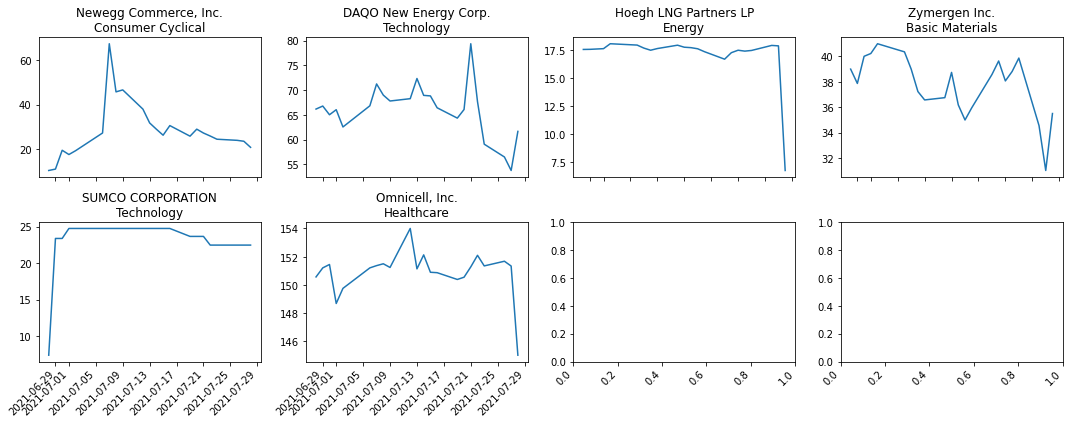

                          Cluster number: 1


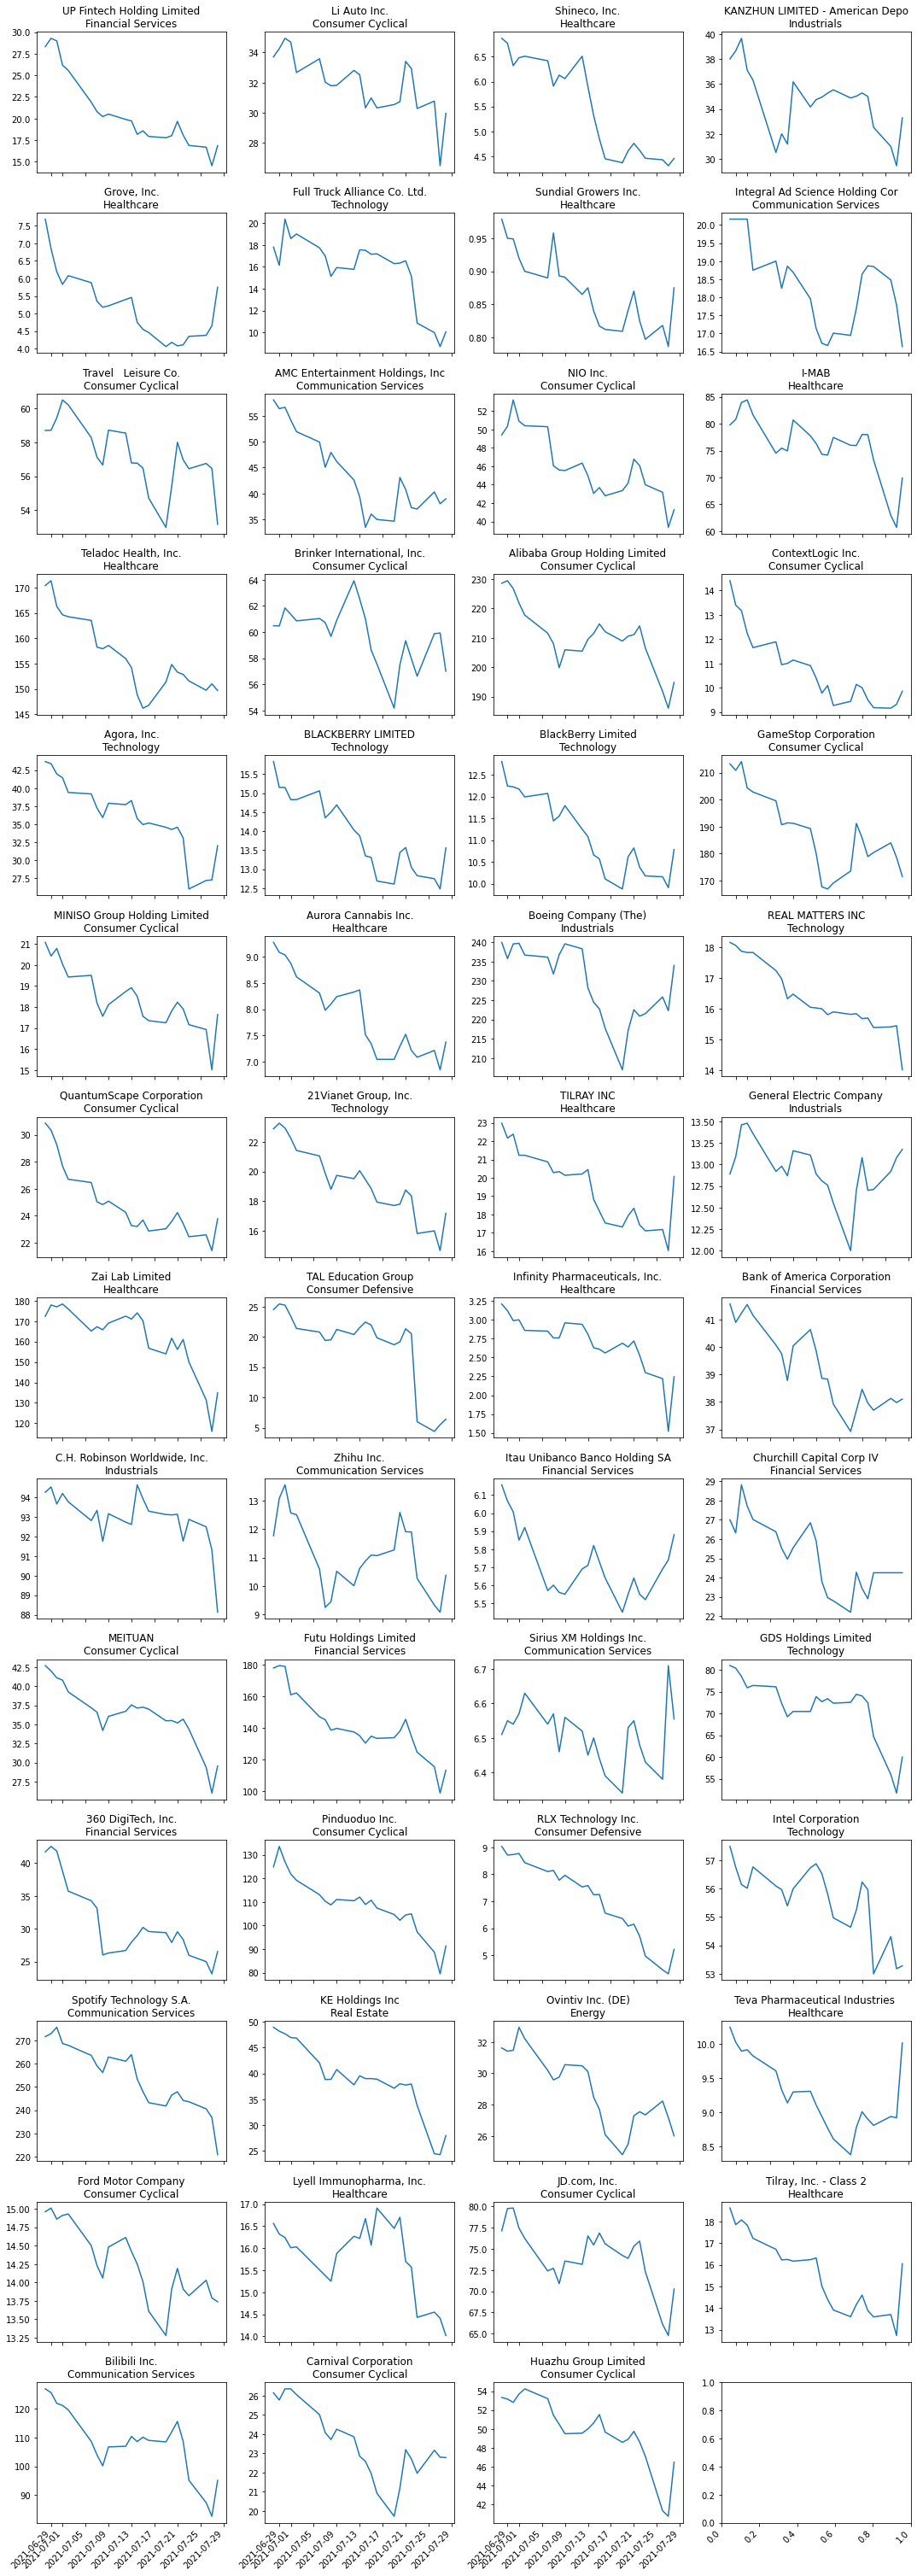

                          Cluster number: 2


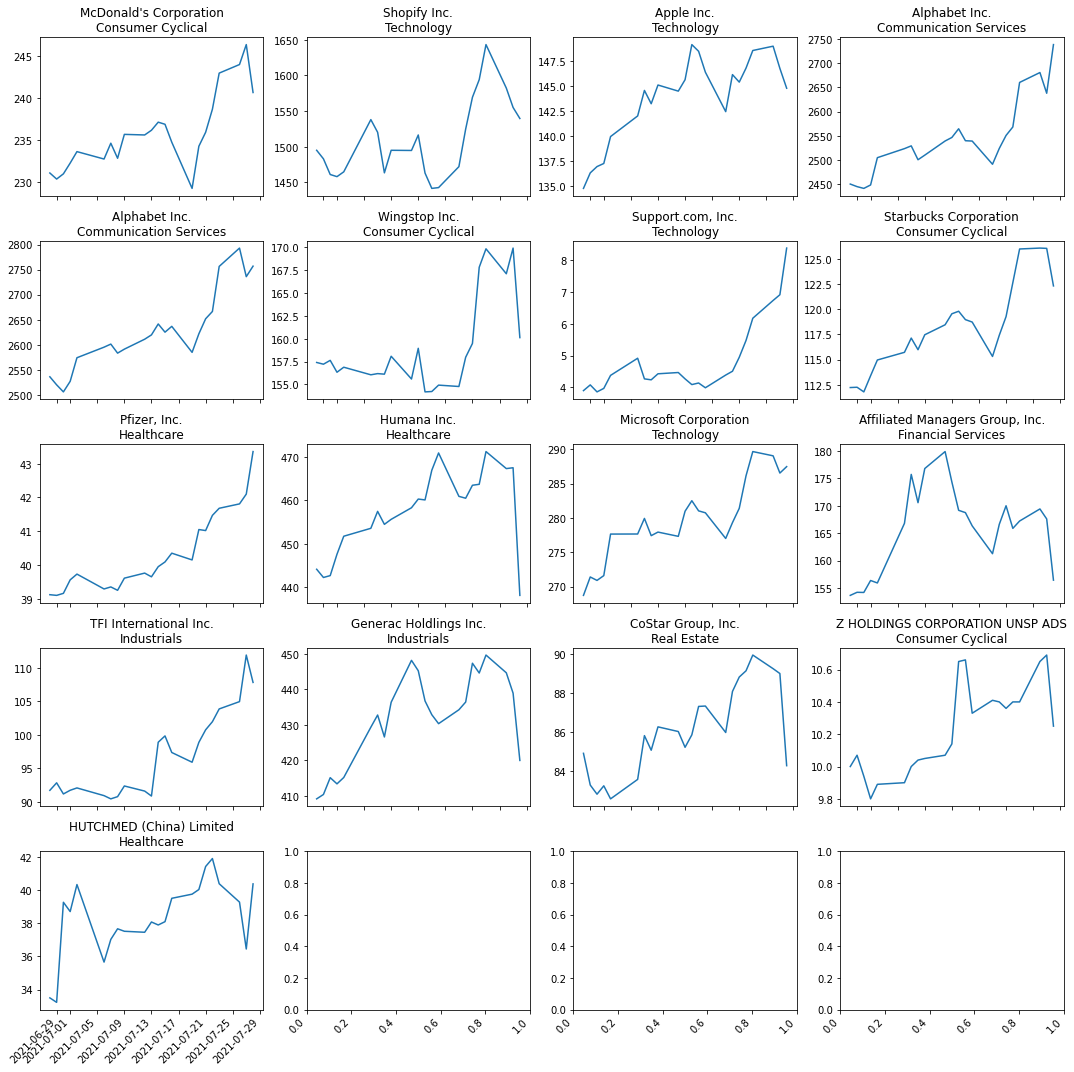

                          Cluster number: 3


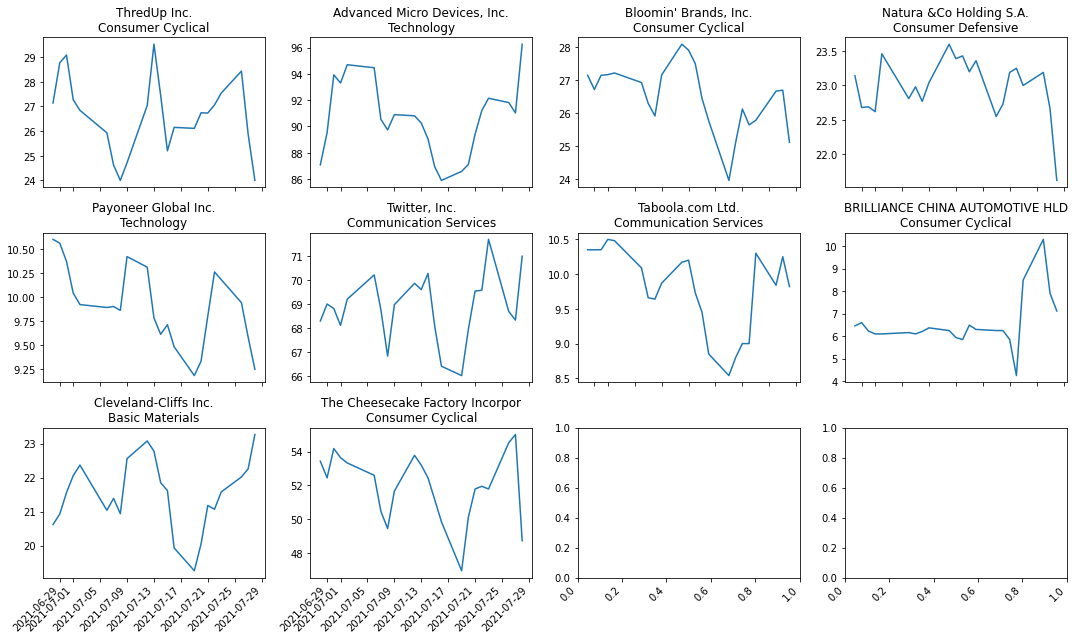

In [31]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

### Переведем обратно в текстовый вид

In [46]:
string_tickers = []
for ticker in sax_transformed:
    string_tickers.append(get_string_sax(ticker.ravel(), n_sax_symbols))

string_tickers

['hhgddccccb',
 'ghfeedccfb',
 'hggfgebbbb',
 'bbccdeebfh',
 'cbdcdcadhh',
 'aabeeggefh',
 'hhcbeeeeeb',
 'hggeedbbab',
 'fhgeeffeea',
 'aaccdedceh',
 'hhfgedbbca',
 'hhfedaabfe',
 'ggdachcdeg',
 'ghgdgdbaed',
 'aaccdeedfh',
 'hhgfebbccc',
 'abchgeeddc',
 'ghhddcbceb',
 'ghfdfddefa',
 'ccccccbcgh',
 'hhgeebaccb',
 'fgfehgbacc',
 'bbdcccccfh',
 'hhfcceedeb',
 'hhgeecbcbb',
 'hhgefedcca',
 'eddgfgedha',
 'hggffdbbca',
 'hhgffdbbcb',
 'hhgeebaccc',
 'bghdecaadf',
 'aabcdfecfh',
 'hhgceeccdb',
 'fgfchhcacd',
 'hhgefebbbb',
 'dbfdgggbfe',
 'ghgfgdbabc',
 'hhgedccccb',
 'hhfedccccb',
 'hhgeeeccda',
 'hhgffebbba',
 'ehfdfdbadc',
 'ggfefgedda',
 'ggfefffefa',
 'hgfegeddda',
 'eefeeeedee',
 'hhgdgecabb',
 'ggedeffecd',
 'hgddgcbaef',
 'eghecdbfed',
 'ghfacdegfb',
 'hgebcedabc',
 'ghgefdabbc',
 'hhfdeeeddb',
 'hhfedccddb',
 'ddfbfgaafg',
 'efgefcbbea',
 'bbbbccdegh',
 'hggddeeeea',
 'aacddehfgh',
 'gggdfebaaf',
 'ecccdcddah',
 'hhgdbcdccb',
 'hhfeeeecca',
 'hhgffedcba',
 'aefffffedd',
 'hffefgdc

In [49]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char')
vectorized = vectorizer.fit_transform(string_tickers).toarray()
vectorized

array([[0.        , 0.20794436, 0.81221636, 0.37420058, 0.        ,
        0.        , 0.18710029, 0.34932956],
       [0.        , 0.26763549, 0.52268292, 0.24080807, 0.4496058 ,
        0.53527099, 0.24080807, 0.2248029 ],
       [0.        , 0.78907287, 0.        , 0.        , 0.16569726,
        0.19726822, 0.53248295, 0.16569726],
       [0.        , 0.70415352, 0.45839587, 0.21119004, 0.39430683,
        0.23471784, 0.        , 0.19715341],
       [0.21491835, 0.22009435, 0.64475505, 0.59409716, 0.        ,
        0.        , 0.        , 0.36974055],
       [0.48660685, 0.24916304, 0.        , 0.        , 0.62786037,
        0.24916304, 0.44837454, 0.20928679],
       [0.        , 0.39672911, 0.19369958, 0.        , 0.83309068,
        0.        , 0.        , 0.33323627],
       [0.23323068, 0.71654312, 0.        , 0.21490593, 0.40124467,
        0.        , 0.42981187, 0.20062233],
       [0.20469438, 0.        , 0.        , 0.        , 0.70430294,
        0.62887244, 0.188611

In [50]:
vectorized.shape

(88, 8)

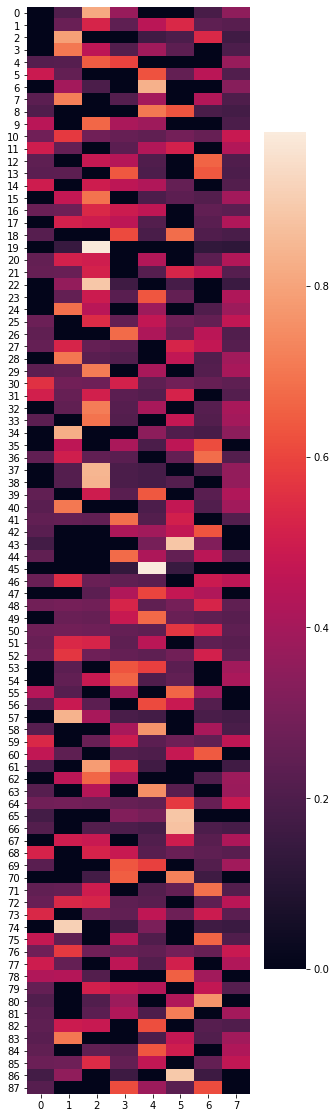

In [51]:
plt.figure(figsize=(5, 20))
sns.heatmap(vectorized);